In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs

import random
import time

from matplotlib import cm
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.manifold import SpectralEmbedding

import umap

### Initial assumptions

In [37]:
# room dimensions in cm. (might break if changed)
width = 140
height = 140


# number of simulated place cells
n_cells = 1000

## Place cell class

In [38]:
# place cell class

class PlaceCell(object):

    def __init__(self, mu, sigma):

        self.mu = mu
        self.sigma = sigma
        
    def gaussian(self, x):
    # def gaussian(self, x, y):
        
        # x = np.array([[x],
        #               [y]])

        xm = x - self.mu
        sigma = self.sigma
        
        # factor1 = ((2*np.pi)**(-k/2)) * np.linalg.det(sigma)**(-1/2)              # normalization -- (turn into a number), peak firing rate
        factor1 = 10            # peak firing rate/ amplitude
        factor2 = np.exp((-1/2) * xm.T @ np.linalg.inv(sigma) @ xm)
        result = factor1 * factor2
        
        return result
        
    def activity(self, x):
    # def activity(self, x, y):
        activity = np.random.poisson(self.gaussian(x))
        # activity = np.random.poisson(self.gaussian(x, y))
        return activity

## Generating and plotting place cells

### Test cell

In [39]:
# test cell

testMu = np.array([[70],    #width
                   [70]])   #height
testSigma = np.array([[80, 0],
                      [0, 80]])
                      
testCell = PlaceCell(testMu, testSigma)

### Plotting test cell

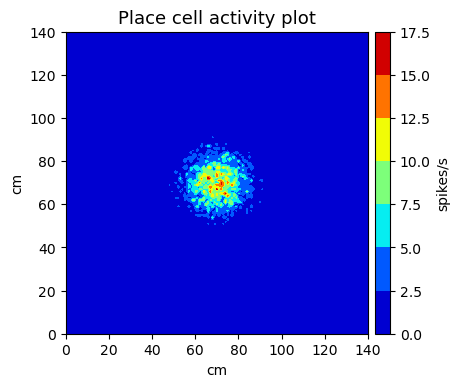

In [40]:
### plotting testCell ###

def plotTestCell(height = height, width = width):
    # be mindful of x and y indicies

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')
    Z = np.zeros((yLen, xLen))

    for y in range(yLen):
        for x in range(xLen):
            element = np.array([[x_coordinates[x]],                         # important to be careful about the indexing
                                [y_coordinates[y]]])
            result = testCell.activity(element)
            Z[y][x] = result

    plt.figure(dpi=100)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')     # vmin=0, vmax=20
    plt.colorbar(label = 'spikes/s', pad = -0.17)    
    plt.title("Place cell activity plot", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.axis('square')
    plt.show()
    pass
    
# np.random.seed(10)
plotTestCell(height, width)

# Testing broadcasting ____________________________

In [41]:
class PlaceCell(object):

    def __init__(self, mu, sigma):

        self.mu = mu
        self.sigma = sigma
        
    def gaussian(self, x):        

        mu = (self.mu).reshape(2,)
        xm = x - mu[..., :]
        invsigma = np.linalg.inv(self.sigma)
        
        alpha = np.einsum('abi,abj,ji->ab', xm, xm, invsigma)

        # factor1 = ((2*np.pi)**(-k/2)) * np.linalg.det(sigma)**(-1/2)              # normalization -- (turn into a number), peak firing rate
        factor1 = 10            # peak firing rate/ amplitude
        factor2 = np.exp((-1/2) * alpha)
        result = factor1 * factor2
        
        return result
        
    def activity(self, x):
        activity = np.random.poisson(self.gaussian(x))
        return activity

In [42]:
testMu = np.array([[70],    #width
                   [70]])   #height
testSigma = np.array([[80, 0],
                      [0, 80]])
                      
testCell = PlaceCell(testMu, testSigma)

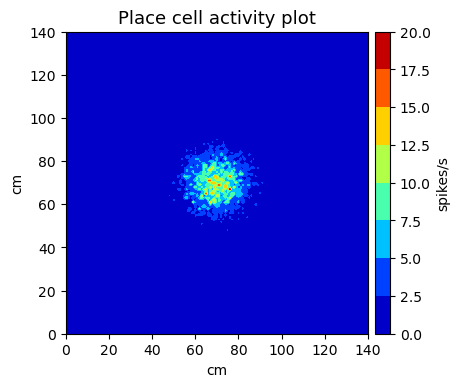

In [43]:
def plotTestCell(height = height, width = width):
    # be mindful of x and y indicies

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')
    XY = np.dstack([X, Y])
    Z = testCell.activity(XY)

    # for y in range(yLen):
    #     for x in range(xLen):
    #         element = np.array([[x_coordinates[x]],                         # important to be careful about the indexing
    #                             [y_coordinates[y]]])
    #         result = testCell.activity(element)
    #         Z[y][x] = result

    plt.figure(dpi=100)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')     # vmin=0, vmax=20
    plt.colorbar(label = 'spikes/s', pad = -0.17)    
    plt.title("Place cell activity plot", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.axis('square')
    plt.show()
    pass
    
# np.random.seed(10)
plotTestCell(height, width)

# Ending testing broadcasting _______________________________________

### Place Cells list

In [44]:
def generatePlaceCells(n_cells, sigma, height = height, width = width):

    cellsList = []
    for i in range(n_cells):
        # mu being location at which the cell is most active 
        mu = np.array([[random.uniform(0,width)],       # width
                       [random.uniform(0,height)]])     # height
        
        cellsList.append(PlaceCell(mu, sigma))
        
    return cellsList

In [45]:
# generating cells list

sigma = np.array([[80, 0],
                  [0, 80]])

random.seed(10)
cellsList = generatePlaceCells(n_cells, sigma, height, width)

# seedReset
random.seed()

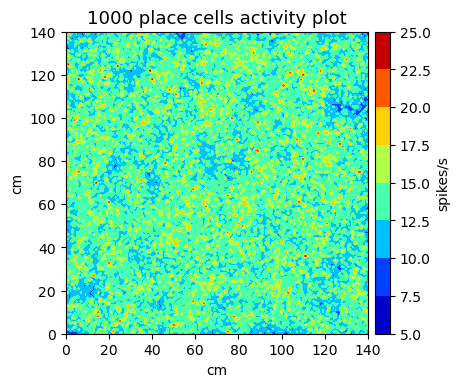

In [46]:
def plotCells(cellsList = cellsList, height = height, width = width):
    # be mindful of x and y indicies

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')
    XY = np.dstack([X, Y])
    Z = np.zeros((yLen, xLen))

    # for y in range(yLen):
    #     for x in range(xLen):
    #         location = np.array([[x_coordinates[x]],                    # important to be careful about the indexing
    #                              [y_coordinates[y]]])
            
    for placeCell in cellsList:
        cellActivity = placeCell.activity(XY)
        Z = np.maximum(Z, cellActivity)


    plt.figure(dpi=100)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')
    plt.colorbar(label = 'spikes/s', pad = -0.17)
    plt.title(str(len(cellsList)) + " place cells activity plot", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.axis('square')
    plt.show()
    pass

# np.random.seed(10)
plotCells()

In [12]:
location = []

for i in range(10**1):
    coordinate = np.array([[random.uniform(0,140)],
                           [random.uniform(0,140)]])
    location.append(coordinate)
    

In [13]:
x_coordinates = np.random.random_sample(5) * 140
y_coordinates = np.random.random_sample(5) * 140

X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')

# print(x_coordinates)
# print(y_coordinates)

print(Y)

[[124.55964334 124.55964334 124.55964334 124.55964334 124.55964334]
 [ 45.82248934  45.82248934  45.82248934  45.82248934  45.82248934]
 [139.36495406 139.36495406 139.36495406 139.36495406 139.36495406]
 [133.91690871 133.91690871 133.91690871 133.91690871 133.91690871]
 [ 35.16839666  35.16839666  35.16839666  35.16839666  35.16839666]]
